In [1]:
# %%writefile Ind_MACD_TRE.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import numpy as np
import pandas as pd

import QUANTAXIS as QA

import tools.Sample_Tools as smpl
from base.JuUnits import excute_for_multidates, roll_multi_result

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.collections import LineCollection



from numba import jit
import numba as nb

@jit(nopython=True)
def calc_deviation(MACD_origin_rolldata, window):
    x = MACD_origin_rolldata
    if x.shape[0] < window:
        return np.nan,np.nan
    x_t = x.T
    MACD = x_t[0]
    origin = x_t[1]
    if MACD is None or origin is None:
        return np.nan,np.nan
    if MACD is np.nan or origin is np.nan:
        return np.nan,np.nan
    
    last_MACD = np.argsort(MACD)[-1]
    last_origin = np.argsort(origin)[-1]

    diff = 0.0
    if last_origin < 1.0:#新低，底背离
        diff = np.abs(last_MACD - last_origin)
        
    if last_origin > 8.0:#新高,顶背离
        diff =  np.abs(last_MACD - last_origin)*-1.0
    return 0,diff


def get_swing_band (MACD,single_stock_df,plot=False,DIFF=None,DEA=None):
    variant = single_stock_df.close
    MACD_DIF = MACD/2
    
    # 𝑇𝑅[𝑡] = max{最高价[t] − 最低价[t], 最高价[t] − 收盘价[t − 1], 收盘价[t − 1] − 最低价[t]}
    HL = single_stock_df.high - single_stock_df.low
    close_last = single_stock_df.close.shift(1)
    HC = single_stock_df.high - close_last
    CL = close_last - single_stock_df.low
    con = HL < HC
    HL[con]=HC[con]
    𝑇𝑅 = HL
    con = 𝑇𝑅 < CL
    𝑇𝑅[con] = CL[con]
    𝐴𝑇𝑅 = TR.rolling(100).mean()

    cum_value=[0.00001]
    def calc_intergral(x,cum):
        if x is np.nan:
            return x
        if np.sign(cum[0]) == np.sign(x):
            cum[0] +=x
        else:
            cum[0] = x
        return cum[0]
    

    # 同号差异累计值
    intergral = MACD_DIF.apply(lambda x: calc_intergral(x,cum_value))
    thres = .5
    delta = 𝐴𝑇𝑅 * thres
    intergral_origin = pd.Series(np.nan,index = intergral.index)
    intergral_origin[intergral >= delta] = 1
    intergral_origin[intergral <= delta*-1] = -1
    intergral_origin[𝐴𝑇𝑅.isna()]=np.nan
    direct = intergral_origin.fillna(method='ffill')

    if plot:
        if DIFF is None or DEA is None:
            raise 'if want to plot, pass DIFF and DEA'
        fig = plt.figure(figsize=(2820/72/2,420/72))
        colors = pd.Series('black',index=variant.index)
        colors[direct>0]='red'
        colors[direct<0]='green'
        ind = range(len(variant))
        xy = pd.DataFrame({"X":ind,"Y":variant},index=variant.index).values.reshape(-1, 1, 2)
        segments = np.hstack([xy[:-1], xy[1:]])
        coll = LineCollection(segments, color=colors)
        coll.set_array(np.random.random(xy.shape[0]))
        ax = fig.gca()
        ax.add_collection(coll)
        ax.autoscale_view()

        ax2 = plt.gca().twinx()
        DIFF.plot(ax=ax2)
        DEA.plot(ax=ax2)
        direct.plot(ax=ax2,color='grey',linestyle=":")

    return direct





def MACD_JCSC(stock_df,main_column='close',SHORT=12,LONG=26,M=9,deviate_window=10):
    def kerrel(single_stock_df):
        main_variant = single_stock_df[main_column]
        DIFF = QA.EMA(main_variant,SHORT) - QA.EMA(main_variant,LONG)
        DEA = QA.EMA(DIFF,M)
        MACD = 2*(DIFF-DEA)

        CROSS_JC = QA.CROSS(DIFF,DEA)
        CROSS_SC = QA.CROSS(DEA,DIFF)
        CROSS = CROSS_JC + CROSS_SC*-1
        
        tmp_df = pd.DataFrame({'MACD':MACD,'main_variant':main_variant},columns=['MACD','main_variant'])
        deviation = tmp_df.dropna().rolling(deviate_window, method='table').apply(lambda x:calc_deviation(x,deviate_window), raw=True, engine='numba')['main_variant']

        swing_band = get_swing_band(MACD,single_stock_df)
        
        return pd.DataFrame({'MACD':MACD,'DIFF':DIFF,'DEA':DEA,'MACD_CROSS':CROSS,'DEVIATE':deviation,'SWING_BAND':swing_band})

    return excute_for_multidates(stock_df, kerrel, level=1)


def MACD_plot(MACD_df,low_frequence=True):
    groups = MACD_df.groupby(level=1)
    assert len(groups)<20,'一次显示不允许超过20组'
    fig = plt.figure(figsize=(2120/72,220*len(groups)/72))
    for idx,item in enumerate(groups):
        inds_ = item[1].reset_index('code',drop=True)
        
        ax = fig.add_subplot(len(groups),1,idx+1)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
        
        ##axis不转成字符串的话，bar和line的x轴有时候对不上，原因未知
        formater = '%Y%m%d' if low_frequence else '%Y%m%d %H%M%S'
        index_ = [pd.to_datetime(x).strftime(formater) for x in inds_.index.values]
        #d = item[1].reset_index(('date','code'),drop=True)
        ax.set_title(item[0],color='r', loc ='left', pad=-10) 
        if 'DIFF' in MACD_df.columns and 'DEA' in MACD_df.columns: 
            DD = inds_[['DIFF','DEA']]
            DD.index = index_
            DD.plot(kind='line', ax=ax)
        macd = inds_['MACD']
        ax.bar(index_,macd.values)
        plt.xticks(rotation = 0)
    

In [131]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = False
if tail:
    file = 'all_tail_qfq'
else:
    file = 'all_train_qfq'
    
df_all = load_cache(file,cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)

data_ = df_all

# year = 2019
# data_ = df_all.loc[str(year)+'-01-03':str(year+1)+'-12-28']

codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()
data_replenish = load_cache_adv(file,
                                dates.min().strftime('%Y-%m-%d'),
                                dates.max().strftime('%Y-%m-%d'),
                                cache_type=CACHE_TYPE.STOCK).sort_index()

ret = smpl.get_forward_return(data_,'close')
ret.name = 'ret_forward'
ret[np.abs(ret)>0.15]=np.nan


In [25]:
MACD_JCSC(data_.loc[(slice(None),'601919'),])


# SHORT=12
# LONG=26
# M=9
# stock_df = data_.loc[(slice(None),'601919'),]
# variant = stock_df.close
# DIFF = QA.EMA(variant, SHORT) - QA.EMA(variant, LONG)
# DEA = QA.EMA(DIFF,M)
# MACD = 2*(DIFF-DEA)

# get_swing_band (MACD,stock_df,plot=True,DIFF=DIFF,DEA=DEA)

,,MACD,DIFF,DEA,MACD_CROSS,DEVIATE,SWING_BAND
date,code,,,,,,
2019-01-03,601919,NaN,NaN,NaN,0,NaN,NaN
2019-01-04,601919,NaN,NaN,NaN,0,NaN,NaN
2019-01-07,601919,NaN,NaN,NaN,0,NaN,NaN
2019-01-08,601919,NaN,NaN,NaN,0,NaN,NaN
2019-01-09,601919,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...
2020-12-22,601919,-0.048264,0.202324,0.226456,0,NaN,-1.0
2020-12-23,601919,-0.028144,0.208866,0.222938,0,NaN,-1.0
2020-12-24,601919,-0.001766,0.221835,0.222718,0,NaN,-1.0


In [123]:
# ret_up>ret_full,  ret_up>0,   ret_up>ret_down:

# all-2  array([0.34539474, 0.40168129, 0.37426901, 1.        ])
# 17-2   array([0.59806184, 0.49746193, 0.59898477, 1.        ])
# 18-2   array([0.6840836 , 0.1607717 , 0.29220257, 1.        ])
# 19-2   array([0.62996595, 0.50170261, 0.45024593, 1.        ])
# 20-2   array([0.10352423, 0.43465492, 0.31754772, 1.        ])

# all-5  array([0.35384615, 0.39250493, 0.37633136, 1.        ])
# 17-5   array([0.39509537, 0.28065395, 0.29972752, 1.        ])
# 18-5   array([0.70439414, 0.07723036, 0.20505992, 1.        ])
# 19-5   array([0.55251142, 0.42770167, 0.25570776, 1.        ])
# 20-5   array([0.06415094, 0.42830189, 0.22641509, 1.        ])

# all-1  array([0.42914244, 0.484375  , 0.48364826, 1.        ])
# 17-1   array([0.60477223, 0.50455531, 0.60780911, 1.        ])
# 18-1   array([0.71927104, 0.20124079, 0.39084917, 1.        ])
# 19-1   array([0.67527123, 0.56416012, 0.56116723, 1.        ])
# 20-1   array([0.12841033, 0.51073117, 0.39614405, 1.        ])

#all-.5  array([0.47572464, 0.53695652, 0.54492754, 1.        ])
#17-.5   array([0.58980892, 0.49384289, 0.585138  , 1.        ])
#18-.5   array([0.73979985, 0.23094688, 0.48229407, 1.        ])
#19-.5   array([0.68780306, 0.60537113, 0.61395002, 1.        ])
#20-.5   array([0.15789474, 0.57096189, 0.45299456, 1.        ])

#22-2   array([0.35783495, 0.52689609, 0.46575342, 1.        ])
#22-5   array([0.2180791 , 0.36271186, 0.27909605, 1.        ])
#22-1   array([0.37686443, 0.5439178 , 0.48955916, 1.        ])
#22-.5  array([0.39656312, 0.56972902, 0.52445473, 1.        ]) 




-0.21070433

In [46]:
MACD_close = MACD_JCSC(data_.close,indicators=['MACD','CROSS','DEVIATE'])

# cur_ret = smpl.get_current_return(data_,'close')
# cur_ret[np.abs(cur_ret)>0.15]=np.nan
# cur_ret = np.log(cur_ret+1)
# cur_ret = excute_for_multidates(cur_ret, lambda x:x.cumsum(), level=1)
# MACD_cur_ret = MACD_JCSC(cur_ret,indicators=['MACD'])

<BarContainer object of 1218 artists>

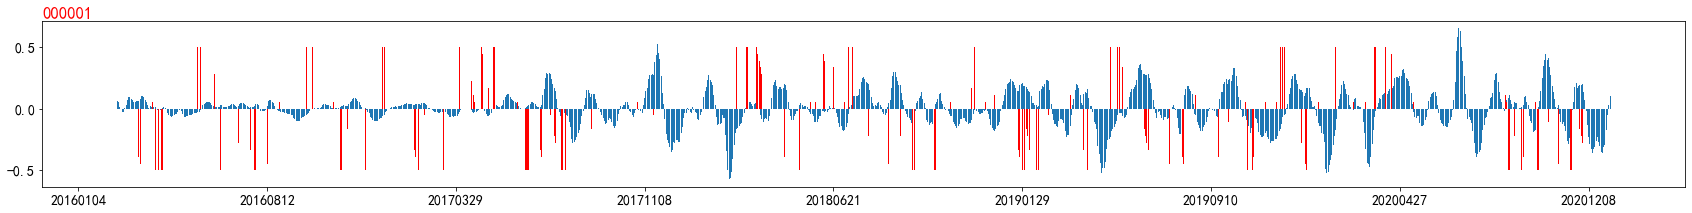

In [53]:
show = MACD_close.loc[(slice(None),MACD_close.index.get_level_values(1).unique()[0]),]
MACD_plot(show)
deviation = show['DEVIATE']
index = [pd.to_datetime(x).strftime('%Y%m%d') for x in deviation.index.get_level_values(0)]
plt.bar(index,(deviation/(deviation.max()*2)).values,color='r')


In [62]:
# MACD_plot(MACD_close.loc[(slice(None),MACD_close.index.get_level_values(1).unique()[0:1]),])

In [ ]:
# 通过新低新高修正波段终点， 效果不好，好不如不修。
# 
# SHORT=12
# LONG=26
# M=9

# # test_code= np.random.choice(data_.index.get_level_values(1).unique())
# def aaaaaa(code,buxiuzheng=False):
#     stock_df = data_.loc[(slice(None),code),]
#     variant = stock_df.close
#     DIFF = QA.EMA(variant, SHORT) - QA.EMA(variant, LONG)
#     DEA = QA.EMA(DIFF,M)
#     MACD_DIF = DIFF-DEA
#     MACD = 2*MACD_DIF


    
#     # 𝑇𝑅[𝑡] = max{最高价[t] − 最低价[t], 最高价[t] − 收盘价[t − 1], 收盘价[t − 1] − 最低价[t]}
#     HL = stock_df.high - stock_df.low
#     close_last = stock_df.close.shift(1)
#     HC = stock_df.high - close_last
#     CL = close_last - stock_df.low
#     con = HL < HC
#     HL[con]=HC[con]
#     𝑇𝑅 = HL
#     con = 𝑇𝑅 < CL
#     𝑇𝑅[con] = CL[con]
#     𝐴𝑇𝑅 = TR.rolling(100).mean()


#     cum_intergral_value=[0.0001]
#     variant_in_swing_band = []
#     except_in_swing_band = [0]
#     direct_in_swing_band = [np.nan]
    
#     thres = .5
#     delta = 𝐴𝑇𝑅 * thres
#     tmp_df = pd.DataFrame({'MACD_DIF':MACD_DIF, 'delta':delta, 'variant':variant},columns=['MACD_DIF', 'delta', 'variant'])
  
#     def calc_direct(da, intergral_cache=None):
#         MACD_DIF_ = da[0][2]
#         delta_ = da[0][3]
#         variant_ = da[0][4]
        
#         if np.isnan(MACD_DIF_) or MACD_DIF_ is None:
#             return np.nan
#         if np.isnan(delta_) or delta_ is None:
#             return np.nan
#         if np.isnan(variant_) or variant_ is None:
#             return np.nan
        
#         ##### intergral 同号差异累计值###################
#         # print(da)
#         # print(MACD_DIF_,delta_,variant_)
        
#         if np.sign(intergral_cache[0]) == np.sign(MACD_DIF_):
#             intergral_cache[0] += MACD_DIF_
#         else:
#             intergral_cache[0] = MACD_DIF_
            
#         res = np.nan
#         if intergral_cache[0] >= delta_:
#             res = 1
#         if intergral_cache[0] <= -delta_:
#             res = -1
        
#         if buxiuzheng:
#             return res
    
#         last_direct = direct_in_swing_band[-1]
        
#         ## 波段还未形成(新波段以及最开始的一段)，无特殊处理，并返回
#         if len(direct_in_swing_band)<5 or np.isnan(last_direct):
#             direct_in_swing_band.append(res)
#             variant_in_swing_band.append(variant_)
#             except_in_swing_band.append(0)
#             return res
        
#         ##正常波段转换
#         if not np.isnan(res) and last_direct != res:
#             direct_in_swing_band.clear()
#             except_in_swing_band.clear()
#             variant_in_swing_band.clear()
#             intergral_cache[0] = MACD_DIF_
            
#             direct_in_swing_band.append(res)
#             except_in_swing_band.append(0)
#             variant_in_swing_band.append(variant_)
#             return res

        
#         # 上行，但创新低
#         e𝑥𝑐𝑒𝑝𝑡 = 1
#         if last_direct == 1:
#             if variant_ < np.min(variant_in_swing_band):
#                 e𝑥𝑐𝑒𝑝𝑡 = -1
        
#         # 下行，但创新高
#         if last_direct == -1:
#             if variant_ > np.max(variant_in_swing_band):
#                 e𝑥𝑐𝑒𝑝𝑡 = -1
        
#         # 强制转换波段
#         if e𝑥𝑐𝑒𝑝𝑡==-1 and except_in_swing_band[-1]==-1:
#             direct_in_swing_band.clear()
#             except_in_swing_band.clear()
#             variant_in_swing_band.clear()
#             intergral_cache[0] = MACD_DIF_
            
#             res = last_direct * -1
#             direct_in_swing_band.append(res)
#             except_in_swing_band.append(0)
#             variant_in_swing_band.append(variant_)
#             return res
        
#         # 正常返回
#         # if np.isnan(res):
#         direct_in_swing_band.append(last_direct)
#         except_in_swing_band.append(e𝑥𝑐𝑒𝑝𝑡)
#         variant_in_swing_band.append(variant_)
#         return res
        
#     # direct
#     res = roll_multi_result(tmp_df, calc_direct, 1, 1,intergral_cache=cum_intergral_value)
#     intergral_origin = pd.Series(res.T[0],index=tmp_df.index,name='direct')
    
#     ##########点位修正##############
#     # 若前一时刻不存在异常状态（𝐸𝑥𝑐𝑒𝑝𝑡[𝑡 − 1] =1），且上下行方向未在𝑡时刻转变时，我们需要判断是否出现异常状态，即是否在
#     # 上行中俯冲破前一个低点或在下行中拉升破前一个高点：
#     # 𝐸𝑥𝑐𝑒𝑝𝑡[𝑡] = {
#     #     −1, 如果(𝐷𝑖𝑟[𝑡] = 1 且收盘价[𝑡] ≤ 前一个低点)或(𝐷𝑖𝑟[𝑡] = −1 且收盘价[𝑡] ≥ 前一个高点)
#     #     1, 如果不出现上述情况
#     # }
#     # 若前一时刻存在异常状态（𝐸𝑥𝑐𝑒𝑝𝑡[𝑡 − 1] = −1），我们需要判断价格走在了上下行之前，抑或是上下行中一个力度较强的回调：
#     # 𝐸𝑥𝑐𝑒𝑝𝑡[𝑡] ={
#     #  −1, 如果不出现下述情况
#     #  1, 如果(𝐷𝑖𝑟[𝑡 − 1]不等于𝐷𝑖𝑟[𝑡])
#     #     或(𝐷𝑖𝑟[𝑡] = 1 且收盘价[𝑡] ≥ 前一个高点)
#     #     或(𝐷𝑖𝑟[𝑡] = −1 且收盘价[𝑡] ≤ 前一个低点)
#     # }
#     # 𝑆𝑡𝑎𝑡𝑢𝑠[𝑡] = 𝐷𝑖𝑟[𝑡] × 𝐸𝑥𝑐𝑒𝑝𝑡[𝑡]
#     # 若𝑆𝑡𝑎𝑡𝑢𝑠 = 1时存在两种情况：上行且没有异常状态、或者下行并出现异常
#     # 状态。在这两种情况中，价格均被判定为处于上涨趋势中，我们需要在前一个低
#     # 点至当前时间点的区间内寻找收盘价的极大值。反之，若𝑆𝑡𝑎𝑡𝑢𝑠 = −1时有两种情
#     # 况：下行且没有异常状态、或者上行并出现异常状态。同样地，在这两种情况下，
#     # 价格被判断为处于下跌趋势，我们应当在前一个高点至当前时间点的区间内寻找
#     # 收盘价的极小值。在𝑆𝑡𝑎𝑡𝑢𝑠发生转变时，价格走势发生转向，我们便可以记录先
#     # 前的区间极大/极小值为高/低点。
    
#     # intergral_origin = pd.Series(np.nan,index = intergral.index)
#     # intergral_origin[intergral >= delta] = 1
#     # intergral_origin[intergral <= delta*-1] = -1
#     # intergral_origin[𝐴𝑇𝑅.isna()]=np.nan
#     direct= intergral_origin.fillna(method='ffill')
    

# #     fig = plt.figure(figsize=(2820/72/2,420/72))
# #     colors = pd.Series('black',index=variant.index)
# #     colors[direct>0]='red'
# #     colors[direct<0]='green'
# #     ind = range(len(variant))
# #     xy = pd.DataFrame({"X":ind,"Y":variant},index=variant.index).values.reshape(-1, 1, 2)
# #     segments = np.hstack([xy[:-1], xy[1:]])
# #     coll = LineCollection(segments, color=colors)
# #     coll.set_array(np.random.random(xy.shape[0]))
# #     ax = fig.gca()
# #     ax.add_collection(coll)
# #     ax.autoscale_view()

# #     ax2 = plt.gca().twinx()
# #     DIFF.plot(ax=ax2)
# #     DEA.plot(ax=ax2)
# #     direct.plot(ax=ax2,color='grey',linestyle=":")
#     r=ret.loc[(slice(None),code),]
#     segm_count = ((fv.dropna()-intergral_origin.dropna().shift(1))!=0).sum()
#     if segm_count < 5:
#         return None
#         # return np.array([0,0,0,0]) 
#     up_segm =(direct>0).sum()
#     down_segm =(direct<0).sum()
#     win_rate = (np.sign(direct[~direct.isna()])==np.sign(r[~direct.isna()])).sum()/(~direct.isna()).sum()
#     ret_full = r.sum()
#     ret_up = r[direct>0].sum()
#     ret_down = r[direct<0].sum()
#     # print(code,segm_count,np.round(win_rate,2),'|',ret_full,ret_up,ret_down)
    
#     res=[]
    
#     if ret_up>ret_full:
#         res.append(1)
#     else:
#         res.append(0)
        
#     if ret_up>0:
#         res.append(1)
#     else:
#         res.append(0)
        
    
#     if ret_up>ret_down:
#         res.append(1)
#     else:
#         res.append(0)
        
#     res.append(1)

#     return ret_up
#     # return np.array(res)

# # final = np.array([0,0,0,0])
# # for code in data_.index.get_level_values(1).unique():
# # # for code in ['000001','000002','000004']:
# #     resualt = aaaaaa(code)
# #     final += resualt

# # final/final[-1]
# test_code= np.random.choice(data_.index.get_level_values(1).unique())
# aaaaaa(test_code,buxiuzheng=True)

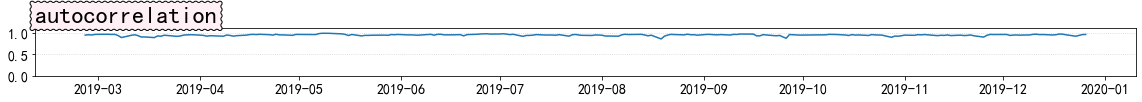

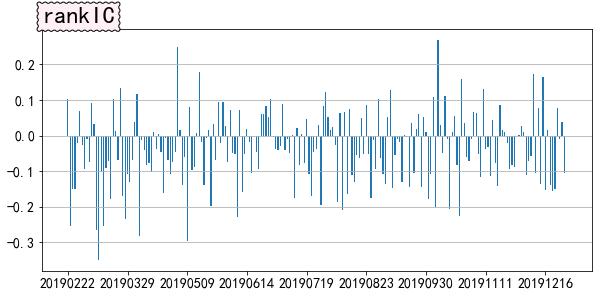

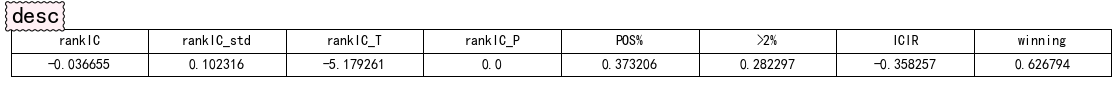

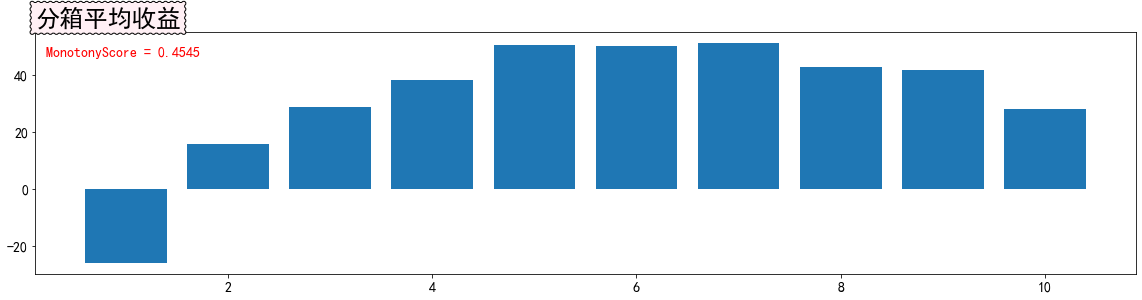

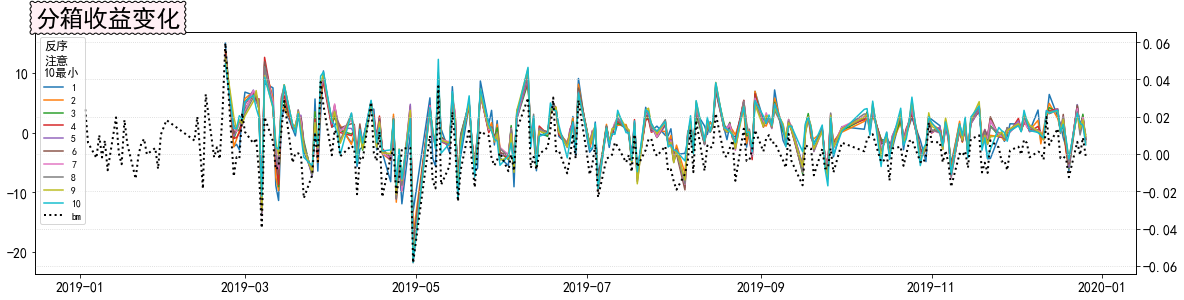

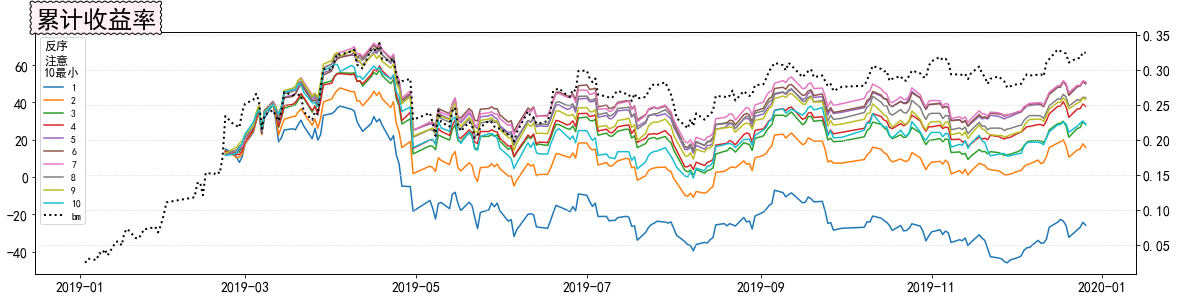

Wall time: 3.61 s


In [148]:
%%time
from tools.Test_Tools_Simple import FactorTest

# %load_ext autoreload
# %autoreload 1
# %aimport tools.Test_Tools_Simple

fa = pd.DataFrame(MACD_close.MACD).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()


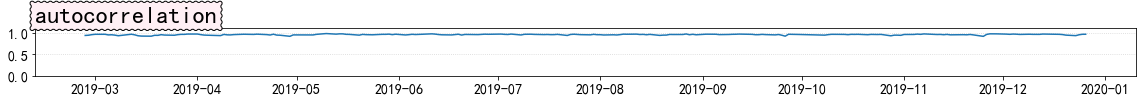

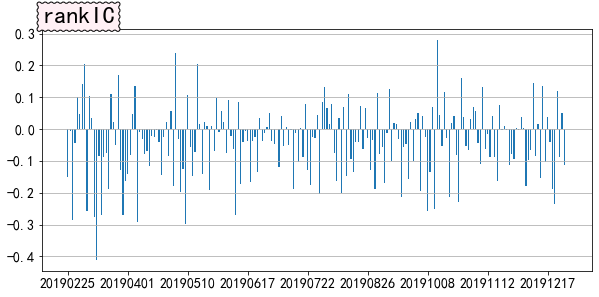

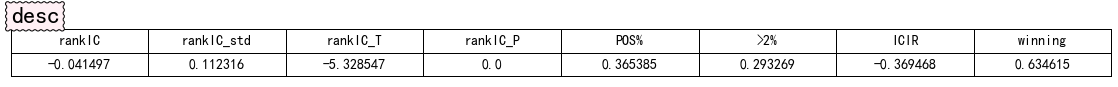

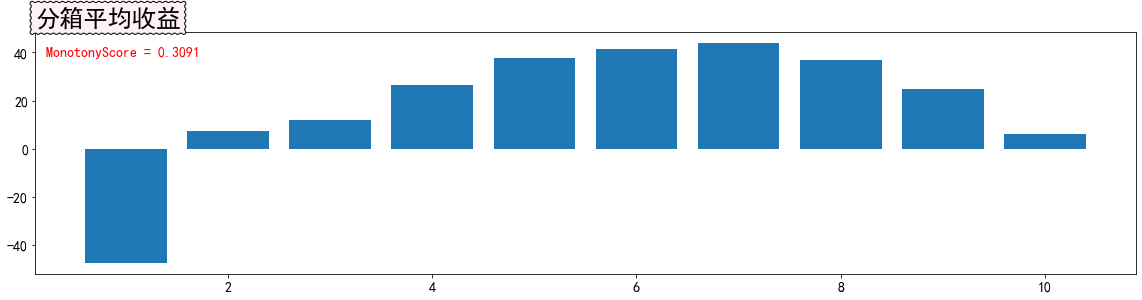

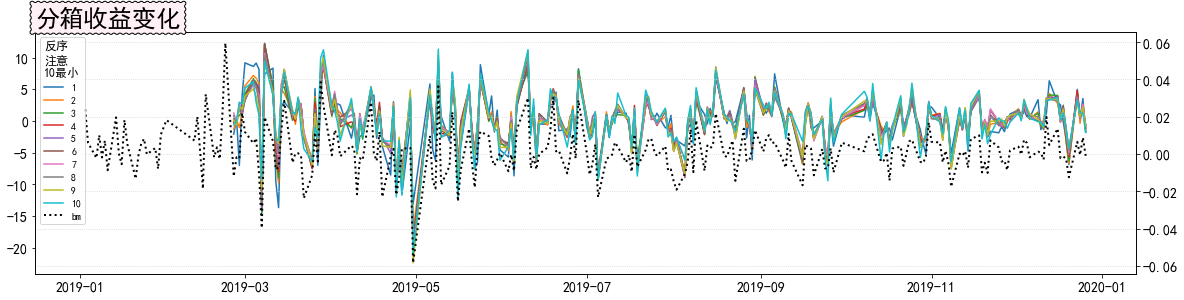

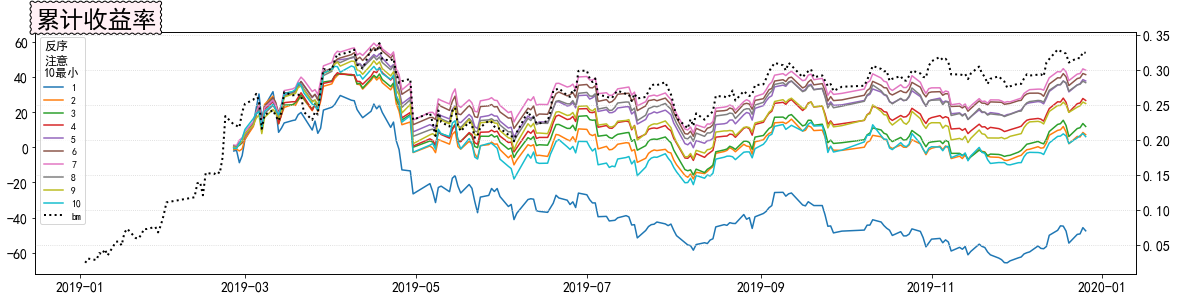

In [149]:
fa = pd.DataFrame(MACD_cur_ret.MACD).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()


In [172]:
df_all.memory_usage(index=True, deep=False)

Index                     12169830
open                      12037700
high                      12037700
low                       12037700
close                     12037700
volume                    24075400
amount                    24075400
adj                       12037700
shares                    24075400
lshares                   24075400
market_value              24075400
liquidity_market_value    24075400
industry                  24075400
dtype: int64